In [1]:
import json
import os
from pathlib import Path
from PIL import Image, ImageOps
import re
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the SDK
from lyft_dataset_sdk.lyftdataset import LyftDataset, view_points
from lyft_dataset_sdk.utils.geometry_utils import BoxVisibility, view_points

In [31]:
data_path = Path(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train")
json_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\data"
lyftdata = LyftDataset(data_path=data_path, json_path=json_path, verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 8.7 seconds.
Reverse indexing ...
Done reverse indexing in 2.8 seconds.


### Because Lyft does not provide ground truth lables for their testing data in their Kaggle competition, we are going to treat the Validation data (taken from the training images and bounding boxes) as our testing data to perform inference on. We randomly split our training and validation data by the date they were recorded. This ensures we control for seasonality of the data and at a minimum ensures that we don't have imagery captures from the same route on the same day.

In [32]:
unique_dates = sorted(list({d["date_captured"] for d in lyftdata.log}))

train_dates = sorted([unique_dates[i] for i in range(len(unique_dates)) if i % 2 == 0])
validation_dates = sorted([unique_dates[i] for i in range(len(unique_dates)) if i % 2 != 0])

train_logs_tokens = list({d["token"] for d in lyftdata.log if d["date_captured"] in train_dates})
validation_logs_tokens = list({d["token"] for d in lyftdata.log if d["date_captured"] in validation_dates})

train_validation_log_tokens = {"train_logs_tokens": train_logs_tokens, "validation_logs_tokens": validation_logs_tokens}

# train_scenes_tokens = list({d["token"] for d in lyftdata.scene if d["log_token"] in train_logs_tokens})
# validation_scenes_tokens = list({d["token"] for d in lyftdata.scene if d["log_token"] in validation_logs_tokens})

# train_sample_tokens = list({d["token"] for d in lyftdata.sample if d["scene_token"] in train_scenes_tokens})
# validation_sample_tokens = list({d["token"] for d in lyftdata.sample if d["scene_token"] in validation_scenes_tokens})

### Define Utility functions to help us get our bounding boxes and corresponding images for our train set and validation set.

In [33]:
#In order to find the image files that contain our pedestrian_anns, we must do the following:
#Accumulate the superset of Samples that contain all of our pedestrian_annotations
def image_category_train_val_split(category_name, lyft_dataset_object, train_validation_log_tokens, category_enumeration, box_size_threshold = 5000, positive_category = None, image_box_lookup = None, box_visibility = BoxVisibility.ALL):
    """
    There wasn't a super clean way in the API to select image files that contain annotations from x class. I adapted the method they use in their .render_annotation() method.

    Args:
    train_validation_log_tokens: We expect this to be a dictionary where the two keys correspond to the training and validation logs respectively. 
    image_box_lookup: While we are iterating over the file path of an image and it's corresponding bounding box coordinates (found in the sample_data table), write these out to a dictionary to use later for IoU object detection comparison.
        The argument specified should be a path specifying the file location to write this dictionary to. 

    Returns two lists: The first is a list of tuples of (file_path, Box object, camera_intrinsic, sample_token, cam) with respect to the training data. The second is a list of the same tuple structure wrt validation data.
    """

    if image_box_lookup:
        img_bx_lookup = {}

    train_val_images_boxes = []

    for train_val_key, split in train_validation_log_tokens.items():

        scenes_tokens = list({d["token"] for d in lyft_dataset_object.scene if d["log_token"] in split})
        sample_tokens = list({d["token"] for d in lyft_dataset_object.sample if d["scene_token"] in scenes_tokens})

        
        annotations = lyft_dataset_object.sample_annotation
        #Filter all annotations down to only annotations our our category of interest.
        category_anns = [d for d in annotations if d["category_name"] == category_name]
        #Filter further to only annotations who belong to our set.
        split_anns = [d for d in category_anns if d["sample_token"] in sample_tokens]

        sample_category_tokens = set()
        for ann in split_anns:
            sample_category_tokens.add(ann["sample_token"])

        category_images_boxes = []
        for sample_token in sample_category_tokens:
            sample_record = lyft_dataset_object.get("sample", sample_token)
            sample_anns = sample_record["anns"]
            cams = [key for key in sample_record["data"].keys() if "CAM" in key]
            
            #We unfortunately do have to iterate through each annotation that exists within the sample_record. There typically aren't more than 20-30 or so.
            #This is because we are in search of the corresponding filepath (and image name) and these must be fetched through .get_sample_data() with the ann supplied as an argument.
            for ann in sample_anns:
                # Figure out which camera the object is fully visible in (this may return nothing)
                for cam in cams:
                    path, box, camera_intrinsic = lyft_dataset_object.get_sample_data(sample_record["data"][cam], box_vis_level=box_visibility, selected_anntokens=[ann])
                    if box:
                        if box[0].name == category_name:
                            #Get the 2D coordinates of our bounding box.
                            box_coords_all = view_points(box[0].corners(), view = camera_intrinsic, normalize=True)[:2, :]
                            # Calculate bounding box coordinates
                            x_min = np.min(box_coords_all[0])
                            y_min = np.min(box_coords_all[1])
                            x_max = np.max(box_coords_all[0])
                            y_max = np.max(box_coords_all[1])
                            box_coords = [x_min, y_min, x_max, y_max]
                            # Calculate the area of the bounding box
                            box_area = (x_max - x_min) * (y_max - y_min)

                            category_images_boxes.append((str(path), box_coords, camera_intrinsic, sample_token, cam, ann))

                            if image_box_lookup and box_area >= box_size_threshold:
                                #Get our label which we want to add to img_bx_lookup so we can pass box coords and corresponding labels to our object detection model.
                                #For binary model where positive categories == 1 and all other categories == 0. 
                                # Otherwise, standard category input corresponding to one of the input categories in category_enumeration.
                                if positive_category:
                                    label = [1 if category_name == positive_category else 0]
                                else:
                                    label = category_enumeration[category_name]
                                
                                #Get the name of the image file itself from the full path.
                                match = re.search(r'images\\(.+)', str(path))
                                if match:
                                    file_name = match.group(1)
                                if file_name in img_bx_lookup:
                                    # If the file_name already exists in the dictionary
                                    img_bx_lookup[file_name]["boxes"].append(box_coords)
                                    img_bx_lookup[file_name]["labels"].append(label)
                                else:
                                    # If the file_name does not exist in the dictionary, create a new entry
                                    img_bx_lookup[file_name] = {"boxes": [box_coords], "labels": [label]}

        train_val_images_boxes.append(category_images_boxes)
        
        # Write our image_box_lookup dict to disk.
        if image_box_lookup:
            out_path = os.path.join(image_box_lookup, train_val_key + f"_{category_name}.json")
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            # Write to a JSON file
            with open(out_path, 'w') as file:
                json.dump(img_bx_lookup, file)

    
    return train_val_images_boxes
    

In [34]:
category_enumeration = {'pedestrian': 1,
 'animal': 2,
 'other_vehicle': 3,
 'bus': 4,
 'motorcycle': 5,
 'truck': 6,
 'emergency_vehicle': 7,
 'bicycle': 8}

categories = [lyftdata.category[i]["name"] for i in range(len(lyftdata.category))]
image_box_lookup = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup"
for cat in categories:

    #We can skip car because we know we aren't doing this one, plus its by far the largest and most timely. Further, it would create a class imbalance.
    if cat != "car":
        #Obtain all of the annotations and their corresponding data via image_class_selector
        cat_train_val_images_boxes = image_category_train_val_split(cat, lyftdata, train_validation_log_tokens, category_enumeration, box_size_threshold=5000, positive_category="pedestrian", image_box_lookup=image_box_lookup)

In [6]:
def crop_to_boundingbox(image_category_train_val_split, output_path, box_area_threshold = 5000):
    path, box_coords, camera_intrinsic, sample_token, cam, ann = image_category_train_val_split
    
    # Calculate bounding box coordinates
    x_min = np.min(box_coords[0])
    y_min = np.min(box_coords[1])
    x_max = np.max(box_coords[0])
    y_max = np.max(box_coords[1])

    # Calculate the area of the bounding box
    box_area = (x_max - x_min) * (y_max - y_min)

    if box_area > box_area_threshold:
        image = Image.open(path)
        match = re.search(r'images\\(.+)', path)

        if match:
            file_name = match.group(1)
        else:
            print("Pattern not found in the path", path)
            pass

        # Crop the image. This is our initial cropping from the full size image. It is with respect to the bounding box size using box_area_threshold.
        # Pillow uses a system of (left, upper, right, lower)
        image_cropped = image.crop((x_min, y_min, x_max, y_max))

        # Check if the directory exists, if not, create it
        Path(output_path).mkdir(parents=True, exist_ok=True)
        #Save the image
        image_cropped.save(os.path.join(output_path, "cropped_" + file_name[:-5] + "_" + ann + file_name[-5:]))

In [7]:
# categories = [lyftdata.category[i]["name"] for i in range(len(lyftdata.category))]
# for cat in categories:

#     #We can skip car because we know we aren't doing this one, plus its by far the largest and most timely.
#     if cat != "car":
#         #Obtain all of the annotations and their corresponding data via image_class_selector
#         cat_train_val_images_boxes = image_category_train_val_split(cat, lyftdata, train_validation_log_tokens= [train_logs_tokens, validation_logs_tokens])

#         cat_train = cat_train_val_images_boxes[0]
#         cat_val = cat_train_val_images_boxes[1]

#         #Do the actual cropping and write cropped images to disk
#         train_image_output_path = os.path.join(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\train_cropped_images", cat +"_cropped")
#         val_image_output_path = os.path.join(r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\validation_cropped_images", cat +"_cropped")
        
#         for i in range(len(cat_train)):
#             crop_to_boundingbox(cat_train[i], output_path=train_image_output_path, box_area_threshold=5000)

#         for i in range(len(cat_val)):
#             crop_to_boundingbox(cat_val[i], output_path=val_image_output_path, box_area_threshold=5000)

## Preprocess pedestrain images with additional processes like Padding and Center cropping for input into image classification model

In [23]:
def dynamic_transform(cropped_images_dir, image_sizes_list, lyftdata, partial_images = False):
    """
    partial_images: If set to true, create additional 
    """


    for size in image_sizes_list:
        categories = [d["name"] for d in lyftdata.category if d["name"] != "car"]
        for category in categories:
            category_dir = os.path.join(cropped_images_dir, category)
            if partial_images:
                new_out_dir = os.path.join(cropped_images_dir, category + "_" + str(size) + "_partials")
            else:
                new_out_dir = os.path.join(cropped_images_dir, category + "_" + str(size))
                
            if not os.path.exists(new_out_dir):
                os.makedirs(new_out_dir)

            #For each image in the directory "category", modify it such that it is resized to "size".
            for image_file in os.listdir(category_dir):
                image_path = os.path.join(category_dir, image_file)
                image_main = Image.open(image_path)
                image_main_width, image_main_height = image_main.size
                images = [image_main]

                if partial_images:
                    image_left = image_main.crop((0, 0, image_main_width // 2, image_main_height))
                    image_right = image_main.crop((0, 0, image_main_width // 2, image_main_height))
                    images.extend([image_left, image_right])

                for image in images:
                    image_width, image_height = image.size

                    if image_width < size or image_height < size:
                        # Calculate padding
                        padding_left = (size - image_width) // 2 if image_width < size else 0
                        padding_top = (size - image_height) // 2 if image_height < size else 0

                        # Adjust for odd total padding
                        padding_right = size - image_width - padding_left
                        padding_bottom = size - image_height - padding_top

                        # Apply padding
                        image = ImageOps.expand(image, (padding_left, padding_top, padding_right, padding_bottom), fill=0)

                    elif image_width > size or image_height > size:
                        # Crop the image to the required size if it's larger
                        image = transforms.CenterCrop(size)(image)

                    # No else case needed, as no action is taken if the image is already the required size
                    if image.size != (size, size):
                        # Raise an exception
                        raise RuntimeError(f"Image size after transformation does not match required size of {size} for image and instead is of size {image.size}: {image_path}. Original image size: {image_width} {image_height}")
                    
                    # Save the transformed image
                    image.save(os.path.join(new_out_dir, image_file))

## Only run the code in the cell below if we haven't yet preprocessed any images or if we need to process them at a new, different size.

In [25]:
# cropped_images_dir = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images\train_cropped_images"
# sizes = [224]
# dynamic_transform(cropped_images_dir, sizes, lyftdata, partial_images=True)

# print("transforms_with_partials done.")

# dynamic_transform(cropped_images_dir, sizes, lyftdata, partial_images=False)

## Combine our image_box_lookup JSON tables for each class into one JSON containing all classes for input into object detection model.

In [35]:
base_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup"
json_files = os.listdir(base_path)
image_box_lookup_train = []
image_box_lookup_validation = []

for file_name in json_files:
    if file_name.startswith("train"):
        full_path = os.path.join(base_path, file_name)
        with open(full_path, "r") as f:
            file = json.load(f)
            image_box_lookup_train.append(file)
    elif file_name.startswith("validation"):
        full_path = os.path.join(base_path, file_name)
        with open(full_path, "r") as f:
            file = json.load(f)
            image_box_lookup_validation.append(file)


def merge_dictionaries(dicts, outpath):
    #dicts must be a list of dictionaries
    combined_dict = {}
    for d in dicts:
        for key, value in d.items():
            if key in combined_dict:
                # Append boxes and labels to existing entry
                combined_dict[key]['boxes'].extend(value['boxes'])
                combined_dict[key]['labels'].extend(value['labels'])
            else:
                # Create new entry
                combined_dict[key] = {'boxes': value['boxes'].copy(), 'labels': value['labels'].copy()}
    with open(outpath, "w") as file:
        json.dump(combined_dict, file, indent=4)



In [2]:
train_merged = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\train_merged.json"
# merge_dictionaries(image_box_lookup_train, train_merged)
validation_merged = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\img_bx_lookup\validation_merged.json"
# merge_dictionaries(image_box_lookup_validation, validation_merged)

In [3]:
with open(train_merged, "r") as file:
    train_merged_file = json.load(file)
with open(validation_merged, "r") as file:
    validation_merged_file = json.load(file)

In [4]:
train_merged_file

{'host-a004_cam0_1232817652451064006.jpeg': {'boxes': [[963.2922978186496,
    676.5313843966901,
    1136.0242514354854,
    776.4546413663261],
   [722.7988805255987, 496.614778432843, 849.0012625293366, 604.402950528869],
   [777.6164623794784, 515.205862285076, 859.8336773765589, 664.184520253418]],
  'labels': [0, 0, 1]},
 'host-a004_cam3_1232817653800897006.jpeg': {'boxes': [[294.33860470392165,
    588.9187878736032,
    401.768542498091,
    653.5364028796939],
   [472.16854068397316,
    442.86560202017677,
    570.0747053954472,
    547.3923696095554],
   [214.58347381764418,
    490.30636899119236,
    297.96140782728247,
    646.8514886862966]],
  'labels': [0, 0, 1]},
 'host-a004_cam1_1232825405634300006.jpeg': {'boxes': [[293.4834527979536,
    584.7624726722335,
    392.69849827114905,
    658.3861469486441],
   [291.8997068032766,
    505.37260293255264,
    366.10607891105167,
    639.317983098597]],
  'labels': [0, 1]},
 'host-a004_cam3_1232817653600897006.jpeg': {'bo

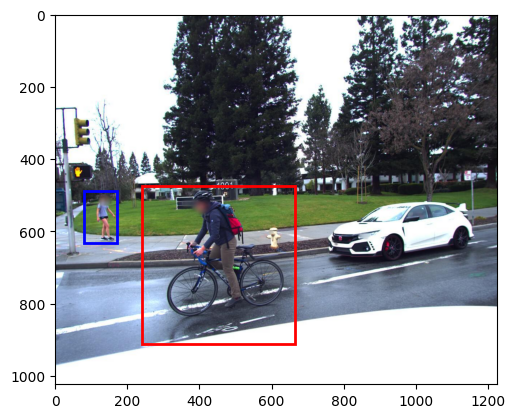

In [48]:
# Load the image
main_images_path = r"S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images"
image_name = "host-a009_cam2_1236014660017752006.jpeg"
image_path = os.path.join(main_images_path, image_name)  # Replace with your image path
image = Image.open(image_path)
boxes = train_merged_file[image_name]["boxes"]
labels = train_merged_file[image_name]["labels"]

# Create a matplotlib figure and axis
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Create a Rectangle patch for the bounding box
for i in range(len(boxes)):
    x_min = boxes[i][0]
    y_min = boxes[i][1]
    x_max = boxes[i][2]
    y_max = boxes[i][3]
    label = labels[i][0]
    color = ["b" if label == 1 else "r"][0]

    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor=color, facecolor='none')
    # Add the rectangle to the plot
    ax.add_patch(rect)

# Display the plot
plt.show()

In [6]:
from PIL import Image
import os
import torchvision.transforms as transforms

from PIL import Image
import os

from PIL import Image, ImageOps

def resize_and_overwrite_images_in_directory(directory, max_width, max_height):
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    total_images = len(image_files)
    processed_images = 0

    for filename in image_files:
        filepath = os.path.join(directory, filename)
        with Image.open(filepath) as img:
            width, height = img.size

            # Crop if larger
            if width > max_width or height > max_height:
                new_width = min(width, max_width)
                new_height = min(height, max_height)
                left = (width - new_width) / 2
                top = (height - new_height) / 2
                right = (width + new_width) / 2
                bottom = (height + new_height) / 2
                img = img.crop((left, top, right, bottom))

            # Pad if smaller
            if img.size[0] < max_width or img.size[1] < max_height:
                padding_left = (max_width - img.size[0]) // 2
                padding_top = (max_height - img.size[1]) // 2
                padding_right = max_width - img.size[0] - padding_left
                padding_bottom = max_height - img.size[1] - padding_top
                img = ImageOps.expand(img, (padding_left, padding_top, padding_right, padding_bottom))

            img.save(filepath)

        processed_images += 1
        if processed_images % (total_images // 10) == 0 or processed_images == total_images:
            print(f"Processed {processed_images / total_images * 100:.0f}% of images")

    print("Processing complete.")


directory_path = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images'
resize_and_overwrite_images_in_directory(directory_path, max_width=1224, max_height=1024)


Processed 10% of images
Processed 20% of images
Processed 30% of images
Processed 40% of images
Processed 50% of images
Processed 60% of images
Processed 70% of images
Processed 80% of images
Processed 90% of images
Processed 100% of images
Processed 100% of images
Processing complete.


In [5]:
from PIL import Image
import os

def crop_image_extremities(directory, height_range=None, width_range=None):
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]
    total_images = len(image_files)
    processed_images = 0

    for filename in image_files:
        filepath = os.path.join(directory, filename)
        with Image.open(filepath) as img:
            width, height = img.size

            # Determine cropping coordinates
            left = width_range[0] if width_range else 0
            upper = height_range[0] if height_range else 0
            right = width_range[1] if width_range else width
            lower = height_range[1] if height_range else height

            # Crop the image if necessary
            if width_range or height_range:
                img_cropped = img.crop((left, upper, right, lower))
                img_cropped.save(filepath)

        processed_images += 1
        if processed_images % (total_images // 10) == 0 or processed_images == total_images:
            print(f"Processed {processed_images / total_images * 100:.0f}% of images")

    print("Processing complete.")

# Example usage
directory_path = r'S:\MADS\Capstone\3d-object-detection-for-autonomous-vehicles\Train\images'
crop_image_extremities(directory_path, height_range=(300, 1100), width_range=None)


Processed 10% of images
Processed 20% of images
Processed 30% of images
Processed 40% of images
Processed 50% of images
Processed 60% of images
Processed 70% of images
Processed 80% of images
Processed 90% of images
Processed 100% of images
Processed 100% of images
Processing complete.
